### Read in Pickled Data

In [55]:
import pandas as pd
df = pd.read_pickle('credit_card_df.pkl')

In [56]:
df.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment', 'missed_payments', 'Total_Bill_Amt', 'Total_Pay_Amt',
       'pay_variance', 'bill_variance', 'avg_bill_amt', 'max_bill',
       'adjusted_pay_variance', 'pay_bill_var_ratio', 'adjusted_bill_var',
       'max_bill_to_cred_lim', 'paid_limit_ratio'],
      dtype='object')

### Choose Evaluation Metric

Credit card default is important to predict because it is costly to the bank who will not get paid, and more costly to the client, who will suffer credit-score damage, legal action, and diminished wages/assets.

In predicting who then you can take the following actions:
    1. Send Payment Reminders to Clients in advance
    2. Schedule meetings to discuss repayment plans / financial habits
    3. Rework loan / limit balance
    4. In cases with large loans, personally call client and make sure they pay to avoid foreclosures
    
It is much more costly for the bank and the client to incur loan default than to simply send reminder emails. Thus the metrics I will choose to evaluate the model are these in order of importance)

    1. Recall - want to capture everyone who will default
    2. Accuracy - see how well model can differentiate since sending mass emails may incur some cost
    3. F1 - try to minimize false positives if we can but this is last priority

In [57]:
df.shape[0]

30000

### Baseline Model

In [58]:
import numpy as np
from sklearn.metrics import recall_score, accuracy_score, f1_score
def dummy_model(df):
    '''
    Create model that randomly predicts a default 22% of the time 
    in concordance with the dataset's ratio of 22% defaults
    '''
    X,y = df.drop(['default_payment'], axis = 1), df['default_payment'].astype(int)
    y_pred = np.random.choice([0, 1], size=X.shape[0], p=[.78, .22])
    print('accuracy: ', accuracy_score(y, y_pred))
    print('recall: ', recall_score(y, y_pred))
    print('f1: ', f1_score(y, y_pred))

In [59]:
dummy_model(df)

accuracy:  0.6569666666666667
recall:  0.21880650994575046
f1:  0.22008336491095112


# EDA:

### Formatting

In [60]:
#df.info()
# we see several columns are object type and must convert to numeric

df = df.apply(pd.to_numeric, errors='coerce')


### Deal w Null / Infinite Vals

In [61]:
### infinity values are caused by dividing by 0. Let's turn all of them into NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [62]:
#print(df.isna().sum())
#we see pay_bill_var_ratio has most null vals. this measures the pay variance compared to bill variance
#     which measures how reliable a custuomer's payment is compared to how much that customer is spending
#     in these examples bill_var is 0, which means spend is consistent
#     these individuals most likely will not default
#     let's impute with 0
df[df['pay_bill_var_ratio'].isnull()].iloc[:,11:].describe
df['pay_bill_var_ratio']=df['pay_bill_var_ratio'].fillna(0)

# adjusted_bill_var and adjusted_pay_var has 2nd and 3rd most nulls
#     these measure how much the bill and pay varies, adjusted to the avg billing amount or total payment amt
#     in most of the examples bill and payment amts are 0
#     let's impute with 0
df[df['adjusted_bill_var'].isnull()].iloc[:, 12:]

df['adjusted_bill_var']=df['adjusted_bill_var'].fillna(0)
df['adjusted_pay_variance']=df['adjusted_pay_variance'].fillna(0)

### Look for outliers


In [63]:
#convert education to categorical
df.describe()

df.iloc[:, 24:]

,default_payment,missed_payments,Total_Bill_Amt,Total_Pay_Amt,pay_variance,bill_variance,avg_bill_amt,max_bill,adjusted_pay_variance,pay_bill_var_ratio,adjusted_bill_var,max_bill_to_cred_lim,paid_limit_ratio
0,1,5,7704.0,689.0,689.0,3913.0,1284.000000,3913.0,0.536604,0.176080,3.047508,0.195650,0.034450
1,1,2,17077.0,5000.0,2000.0,1730.0,2846.166667,3455.0,0.702700,1.156069,0.607835,0.028792,0.041667
2,0,0,101653.0,11018.0,4000.0,15680.0,16942.166667,29239.0,0.236097,0.255102,0.925501,0.324878,0.122422
3,0,0,231334.0,8388.0,1019.0,20977.0,38555.666667,49291.0,0.026429,0.048577,0.544070,0.985820,0.167760
4,0,0,109339.0,59049.0,36002.0,30165.0,18223.166667,35835.0,1.975617,1.193502,1.655311,0.716700,1.180980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,725349.0,42550.0,19000.0,192385.0,120891.500000,208365.0,0.157166,0.098760,1.591386,0.947114,0.193409
29996,0,2,21182.0,14490.0,8998.0,8979.0,3530.333333,8979.0,2.548768,1.002116,2.543386,0.059860,0.096600
29997,1,2,70496.0,31300.0,22000.0,18120.0,11749.333333,20878.0,1.872447,1.214128,1.542215,0.695933,1.043333
29998,1,0,266611.0,147181.0,84722.0,80024.0,44435.166667,78379.0,1.906643,1.058707,1.800916,0.979738,1.839762


### pairplot on just engineered features

In [64]:
%%time

import seaborn as sns

#sns.pairplot(df.iloc[:, 24:], hue = 'default_payment');

CPU times: user 9 µs, sys: 22 µs, total: 31 µs
Wall time: 34.1 µs


Interaction between pay_bill_var_ratio and missed_payments is interesting

key variables: 
- adjusted_pay_variance
- pay_bill_var_ratio
- missed_payments
- paid_limit_ratio

### deal w/ outliers

In [65]:
describe_df = df.describe()
describe_df

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,Total_Pay_Amt,pay_variance,bill_variance,avg_bill_amt,max_bill,adjusted_pay_variance,pay_bill_var_ratio,adjusted_bill_var,max_bill_to_cred_lim,paid_limit_ratio
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,3.165139e+04,1.460458e+04,2.885023e+04,44976.945200,6.057244e+04,1.301384,0.902980,1.249224,0.494965,0.233451
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,6.082768e+04,3.743662e+04,4.760694e+04,63260.721860,7.840481e+04,40.299729,8.696298,16.761040,0.433046,0.315753
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,-56043.166667,-6.029000e+03,-2676.000000,0.000000,-2503.714286,-0.100000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,6.679750e+03,1.500000e+03,4.011000e+03,4781.333333,1.006000e+04,0.046364,0.104062,0.203737,0.070636,0.067714
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,1.438300e+04,3.600000e+03,1.159350e+04,21051.833333,3.120850e+04,0.169008,0.513837,0.849538,0.430702,0.156667
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,3.350350e+04,1.044600e+04,3.315175e+04,57104.416667,7.959900e+04,1.500000,1.000000,2.024955,0.923246,0.263153
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,3.764066e+06,1.679893e+06,1.682177e+06,877313.833333,1.664089e+06,4776.000000,796.000000,291.717391,10.688575,14.566337


In [66]:
describe_df.loc['75%','adjusted_bill_var']

2.024954676560056

In [67]:
for val in ['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var']:
    df = df[df[val]<5*describe_df.loc['75%', val]]
    df = df[df[val]>describe_df.loc['25%', val]-7]

In [68]:
df

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,Total_Pay_Amt,pay_variance,bill_variance,avg_bill_amt,max_bill,adjusted_pay_variance,pay_bill_var_ratio,adjusted_bill_var,max_bill_to_cred_lim,paid_limit_ratio
0,1,20000,2,2,1,24,2,2,-1,-1,...,689.0,689.0,3913.0,1284.000000,3913.0,0.536604,0.176080,3.047508,0.195650,0.034450
1,2,120000,2,2,2,26,-1,2,0,0,...,5000.0,2000.0,1730.0,2846.166667,3455.0,0.702700,1.156069,0.607835,0.028792,0.041667
2,3,90000,2,2,2,34,0,0,0,0,...,11018.0,4000.0,15680.0,16942.166667,29239.0,0.236097,0.255102,0.925501,0.324878,0.122422
3,4,50000,2,2,1,37,0,0,0,0,...,8388.0,1019.0,20977.0,38555.666667,49291.0,0.026429,0.048577,0.544070,0.985820,0.167760
4,5,50000,1,2,1,57,-1,0,-1,0,...,59049.0,36002.0,30165.0,18223.166667,35835.0,1.975617,1.193502,1.655311,0.716700,1.180980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,29995,80000,1,2,2,34,2,2,2,2,...,21500.0,7000.0,10050.0,78488.833333,82607.0,0.089185,0.696517,0.128044,1.032587,0.268750
29995,29996,220000,1,3,1,39,0,0,0,0,...,42550.0,19000.0,192385.0,120891.500000,208365.0,0.157166,0.098760,1.591386,0.947114,0.193409
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,14490.0,8998.0,8979.0,3530.333333,8979.0,2.548768,1.002116,2.543386,0.059860,0.096600
29997,29998,30000,1,2,2,37,4,3,2,-1,...,31300.0,22000.0,18120.0,11749.333333,20878.0,1.872447,1.214128,1.542215,0.695933,1.043333


### heatmap to check for multicollinearity

In [69]:
import matplotlib.pyplot as plt
# plt.figure(figsize = [15,15])
# sns.heatmap(df.corr())

In [70]:
#potential columns to drop:
droppers = ['bill_amt1', 'bill_amt2', 'bill_amt3','bill_amt4', 'bill_amt5', 'bill_amt6', 
            'Total_Bill_Amt', 'max_bill', 'pay_variance', 'bill_variance',  'pay_5', 'pay_6', 'id']

#'pay_0', 'pay_2','pay_3', 'pay_4',

### Investigate Distribution of Key Variables

will have to readjust skew

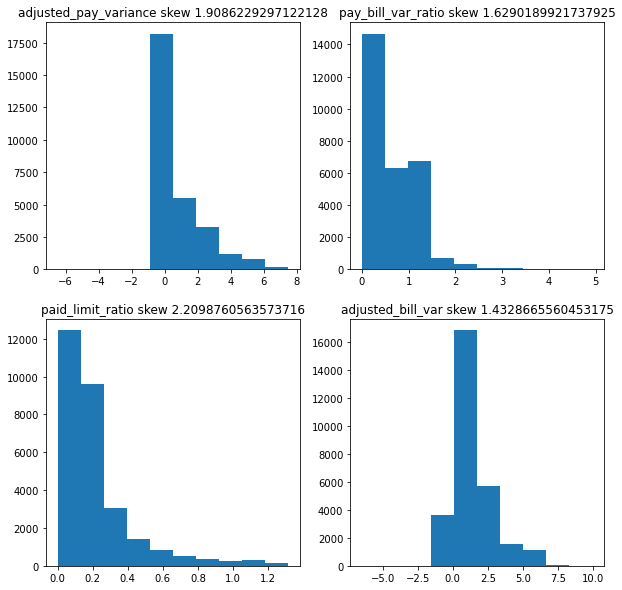

In [71]:
from scipy.stats import skew
plt.figure(figsize = [10,10])
for i,val in enumerate(['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var']):
    plt.subplot(2,2,i+1)
    plt.hist(df[val])
    plt.title(val + ' skew ' + str(skew(df[val])))
    

In [72]:
#all have significant right skews

for val in ['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var']:
    df[val] = np.log1p(df[val])

/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [73]:
## check to see if skew has been fixed
# from scipy.stats import skew
# plt.figure(figsize = [10,10])
# for i,val in enumerate(['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var']):
#     plt.subplot(2,2,i+1)
#     plt.hist(df[val])
#     plt.title(val + ' skew ' + str(skew(df[val])))
    

### Group by target, look at means/distributions of features

In [74]:
target_table = df.groupby('default_payment')['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var'].mean()
target_table

<ipython-input-74-1a543e830a41>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  target_table = df.groupby('default_payment')['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var'].mean()


,adjusted_pay_variance,pay_bill_var_ratio,paid_limit_ratio,adjusted_bill_var
default_payment,,,,
0,0.491628,0.405044,0.180562,0.727675
1,-inf,0.411323,0.165286,0.554441


(array([   14., 10172.,     0., 13612.,     0.,  4756.,   118.,     0.,
          269.,    45.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

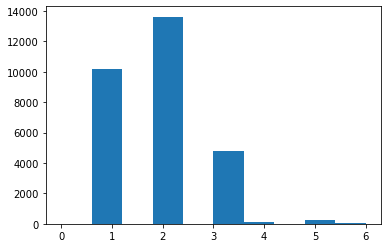

In [75]:
plt.hist(df['education'])

### Create Categorical Variables

In [76]:
df['sex'] = df['sex'].replace(2,'female')
df['sex'] = df['sex'].replace(1,'male')

In [77]:
df['education'] = df['education'].replace(1, 'graduate_school')
df['education'] = df['education'].replace(2, 'university')
df['education'] = df['education'].replace(3, 'high_school')
df['education'] = df['education'].replace(4, 'other')

In [78]:
df['marriage'] = df['marriage'].replace(1, 'married')
df['marriage'] = df['marriage'].replace(2, 'single')
df['marriage'] = df['marriage'].replace(3, 'other')

###  Groupbys for categorical variables

In [79]:
target_table = df.groupby('default_payment')['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var'].mean()
target_table

<ipython-input-79-1a543e830a41>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  target_table = df.groupby('default_payment')['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var'].mean()


,adjusted_pay_variance,pay_bill_var_ratio,paid_limit_ratio,adjusted_bill_var
default_payment,,,,
0,0.491628,0.405044,0.180562,0.727675
1,-inf,0.411323,0.165286,0.554441


In [80]:
target_table = df.groupby('education')['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var'].mean()
target_table

<ipython-input-80-a7f3bc9c8030>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  target_table = df.groupby('education')['adjusted_pay_variance','pay_bill_var_ratio', 'paid_limit_ratio', 'adjusted_bill_var'].mean()


,adjusted_pay_variance,pay_bill_var_ratio,paid_limit_ratio,adjusted_bill_var
education,,,,
0,1.095541,0.636963,0.147915,1.245691
5,0.400254,0.318452,0.198018,0.785226
6,0.428402,0.314786,0.232568,0.816671
graduate_school,-inf,0.446078,0.160200,0.788133
high_school,0.385003,0.381336,0.188920,0.632368
other,0.705042,0.423721,0.142324,1.005343
university,-inf,0.387253,0.185458,0.629351


### check correlations again

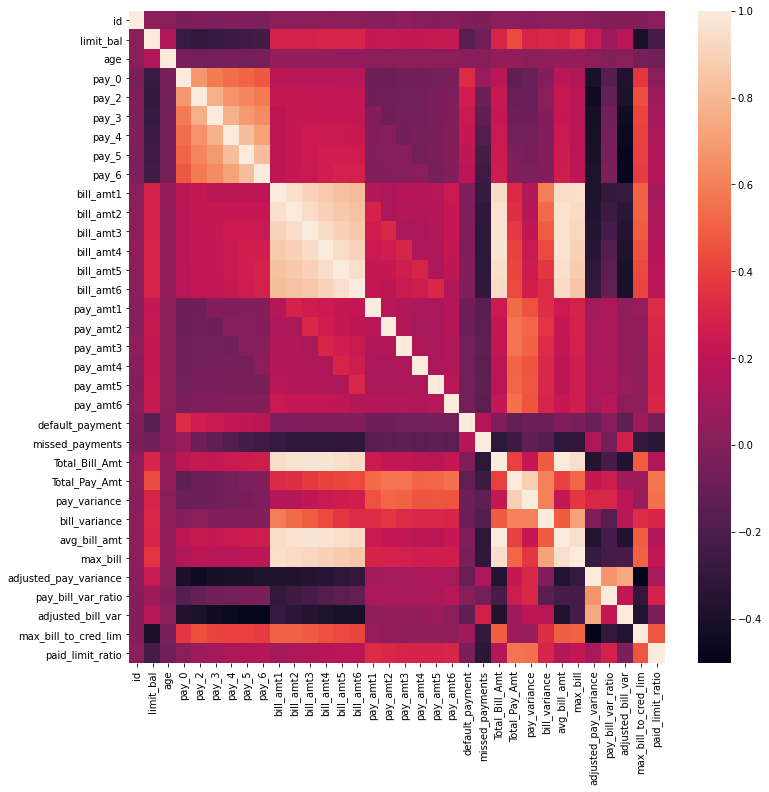

In [81]:
plt.figure(figsize =(12,12))
sns.heatmap(df.corr())

In [82]:
df.describe().iloc[:,19:]

,pay_amt5,pay_amt6,default_payment,missed_payments,Total_Bill_Amt,Total_Pay_Amt,pay_variance,bill_variance,avg_bill_amt,max_bill,adjusted_pay_variance,pay_bill_var_ratio,adjusted_bill_var,max_bill_to_cred_lim,paid_limit_ratio
count,28986.000000,28986.000000,28986.000000,28986.000000,2.898600e+04,2.898600e+04,28986.000000,28986.000000,28986.000000,28986.000000,2.895500e+04,28986.000000,28935.000000,28986.000000,28986.000000
mean,4578.103395,4345.732492,0.222832,1.221038,2.743706e+05,2.928702e+04,13041.873387,28635.659870,45728.427367,61227.109294,-inf,0.406443,0.689095,0.497332,0.177158
std,14002.558157,13649.700554,0.416153,1.720417,3.811546e+05,4.683500e+04,30854.535763,45579.184161,63525.762625,77741.330809,NaN,0.314983,0.546191,0.425196,0.159416
min,0.000000,0.000000,0.000000,0.000000,-3.362590e+05,0.000000e+00,0.000000,0.000000,-56043.166667,-6029.000000,-inf,0.000000,-2.007786,-0.100000,0.000000
25%,279.000000,81.000000,0.000000,0.000000,3.140075e+04,6.618000e+03,1500.000000,4084.000000,5233.458333,10521.250000,4.412196e-02,0.094448,0.183700,0.076510,0.065441
50%,1501.500000,1495.000000,0.000000,0.000000,1.314720e+05,1.400350e+04,3500.000000,11767.000000,21912.000000,32589.000000,1.439767e-01,0.392576,0.600777,0.437444,0.144083
75%,4005.000000,4000.000000,0.000000,2.000000,3.494525e+05,3.227975e+04,10000.000000,33333.750000,58242.083333,80451.250000,8.689650e-01,0.693147,1.097853,0.923565,0.226867
max,426529.000000,422000.000000,1.000000,6.000000,5.263883e+06,1.147803e+06,846040.000000,708323.000000,877313.833333,983931.000000,2.138881e+00,1.780949,2.394417,6.455300,0.839215


### Convert Cats to Numeric

In [83]:
df = pd.get_dummies(df)

In [84]:
df

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,education_5,education_6,education_graduate_school,education_high_school,education_other,education_university,marriage_0,marriage_married,marriage_other,marriage_single
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,0,0,0,0,0,1,0,1,0,0
1,2,120000,26,-1,2,0,0,0,2,2682,...,0,0,0,0,0,1,0,0,0,1
2,3,90000,34,0,0,0,0,0,0,29239,...,0,0,0,0,0,1,0,0,0,1
3,4,50000,37,0,0,0,0,0,0,46990,...,0,0,0,0,0,1,0,1,0,0
4,5,50000,57,-1,0,-1,0,0,0,8617,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,29995,80000,34,2,2,2,2,2,2,72557,...,0,0,0,0,0,1,0,0,0,1
29995,29996,220000,39,0,0,0,0,0,0,188948,...,0,0,0,1,0,0,0,1,0,0
29996,29997,150000,43,-1,-1,-1,-1,0,0,1683,...,0,0,0,1,0,0,0,0,0,1
29997,29998,30000,37,4,3,2,-1,0,0,3565,...,0,0,0,0,0,1,0,0,0,1


# Modeling

In [85]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)
df.shape

(28927, 47)

In [86]:
from sklearn.model_selection import train_test_split

X, y = df.drop('default_payment', axis = 1), df['default_payment']


In [87]:
X.drop(droppers, axis = 1, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X,y)

### balance Data

In [88]:
from imblearn.over_sampling import RandomOverSampler


import imblearn.over_sampling

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 2, 0 : n_neg}

ROS = RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)



### Scale Data

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_tr = scaler.fit_transform(X_tr_rs)
X_te = scaler.transform(X_test)


# Modeling + CV

In [90]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
model_df = pd.DataFrame(columns = ['Name', 'Recall', 'Accuracy', 'Precision', 'F1'])




In [91]:
### Try out Algos

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [93]:
# for algorithm in [KNeighborsClassifier(n_neighbors=10),LogisticRegression(),GaussianNB(), RandomForestClassifier()]:
#     algorithm.fit(X_tr, y_tr_rs)
#     alg_label = str(algorithm)
#     y_pred = algorithm.predict(X_te)
#     print(alg_label, '-'*10, '\n')
#     print('acccuracy: ', accuracy_score(y_test, y_pred))
#     print('recall: ', recall_score(y_test, y_pred))
#     print('f1: ', f1_score(y_test, y_pred))


### Logistic Regression

In [94]:
from sklearn.model_selection import GridSearchCV
LR = LogisticRegression()
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.08, .1, .2, .3, .4]
}

grid_search = GridSearchCV(estimator=LR,
             param_grid=param_grid, scoring = 'recall', cv = 5)

grid_search.fit(X_tr, y_tr_rs)
best_params = grid_search.best_params_
print(best_params)


/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit fai

/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test pa

{'C': 0.08, 'penalty': 'l2'}


In [95]:
LR1 = LogisticRegression(penalty = 'l2', C = .2)

LR1.fit(X_tr, y_tr_rs)
y_pred = LR1.predict(X_te)


model_df = model_df.append({'Name': 'Logistic Reg', 'Recall':np.mean(cross_val_score(LR1, X_tr, y_tr_rs, cv=kf, scoring='recall')),
                           'Accuracy':np.mean(cross_val_score(LR1, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
                            'Precision': np.mean(cross_val_score(LR1, X_tr, y_tr_rs, cv=kf, scoring='precision')),
                           'F1': np.mean(cross_val_score(LR1, X_tr, y_tr_rs, cv=kf, scoring='f1'))}, ignore_index = True)


### Gaussian Naive Bayes

In [96]:
GNB = GaussianNB()
GNB.fit(X_tr, y_tr_rs)
y_pred = GNB.predict(X_te)

model_df = model_df.append({'Name': 'Gaussian NB', 'Recall':np.mean(cross_val_score(GNB, X_tr, y_tr_rs, cv=kf, scoring='recall')),
                           'Accuracy':np.mean(cross_val_score(GNB, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
                            'Precision': np.mean(cross_val_score(GNB, X_tr, y_tr_rs, cv=kf, scoring='precision')),
                           'F1': np.mean(cross_val_score(GNB, X_tr, y_tr_rs, cv=kf, scoring='f1'))}, ignore_index = True)


In [97]:
model_df

,Name,Recall,Accuracy,Precision,F1
0,Logistic Reg,0.486386,0.744125,0.713301,0.578254
1,Gaussian NB,0.975533,0.400076,0.373209,0.539859


### KNN


In [98]:
# for i in np.arange(1,30):
#     knn = KNeighborsClassifier(n_neighbors = i)
#     knn.fit(X_tr, y_tr_rs)
#     y_pred = knn.predict(X_te)
#     print(i, np.mean(cross_val_score(knn, X_tr, y_tr_rs, cv=kf, scoring='recall')))
# # we found out best recall is actually with n_neighbors = 1


In [99]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors':[1,2,3]
}

grid_search = GridSearchCV(estimator=knn,
             param_grid=param_grid, scoring = 'recall', cv = 5)

grid_search.fit(X_tr, y_tr_rs)
best_params = grid_search.best_params_
print(best_params)


{'n_neighbors': 1}


In [100]:

KNN = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'])
KNN.fit(X_tr, y_tr_rs)
y_pred = KNN.predict(X_te)

model_df = model_df.append({'Name': 'KNN', 'Recall':np.mean(cross_val_score(KNN, X_tr, y_tr_rs, cv=kf, scoring='recall')),
                           'Accuracy':np.mean(cross_val_score(KNN, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
                            'Precision': np.mean(cross_val_score(KNN, X_tr, y_tr_rs, cv=kf, scoring='precision')),
                           'F1': np.mean(cross_val_score(KNN, X_tr, y_tr_rs, cv=kf, scoring='f1'))}, ignore_index = True)


In [101]:
model_df

,Name,Recall,Accuracy,Precision,F1
0,Logistic Reg,0.486386,0.744125,0.713301,0.578254
1,Gaussian NB,0.975533,0.400076,0.373209,0.539859
2,KNN,0.841706,0.826105,0.722263,0.777409


In [102]:
import pickle

model = KNN
pickle.dump(model, open('pickled_model.p', 'wb'))

### Random Forest

In [103]:
%%time
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [40,60,80],
    'max_depth': [20, 25]
}

grid_search = GridSearchCV(estimator=rfc,
             param_grid=param_grid, scoring = 'recall', cv = 5)

grid_search.fit(X_tr, y_tr_rs)
best_params = grid_search.best_params_
print(best_params)


{'max_depth': 25, 'n_estimators': 80}
CPU times: user 2min 8s, sys: 3.1 s, total: 2min 11s
Wall time: 2min 37s


In [104]:
# rfc = RandomForestClassifier(n_estimators = best_params['n_estimators'], 
#                              max_depth = best_params['max_depth'],
#                              min_samples_leaf = best_params['min_samples_leaf'])

rfc = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                             max_depth = best_params['max_depth'])

# rfc = RandomForestClassifier(n_estimators = 80,
#                              max_depth = 20)
rfc.fit(X_tr, y_tr_rs)
y_pred = rfc.predict(X_te)

rfc.fit(X_tr, y_tr_rs)
y_pred = rfc.predict(X_te)


model_df = model_df.append({'Name': 'RFC', 'Recall':np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='recall')),
                           'Accuracy':np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
                            'Precision': np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='precision')),
                           'F1': np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='f1'))}, ignore_index = True)


In [105]:
model_df

,Name,Recall,Accuracy,Precision,F1
0,Logistic Reg,0.486386,0.744125,0.713301,0.578254
1,Gaussian NB,0.975533,0.400076,0.373209,0.539859
2,KNN,0.841706,0.826105,0.722263,0.777409
3,RFC,0.847361,0.893918,0.857417,0.852812


### Decision Tree

In [106]:
dt = DecisionTreeClassifier()
param_grid = {
    'max_depth': [6,7,9,12,15,20]
}

grid_search = GridSearchCV(estimator=dt,
             param_grid=param_grid, scoring = 'recall', cv = 5)

grid_search.fit(X_tr, y_tr_rs)
best_params = grid_search.best_params_
print(best_params)


{'max_depth': 20}


In [107]:

dt = DecisionTreeClassifier(max_depth = best_params['max_depth'])
dt.fit(X_tr, y_tr_rs)
y_pred = dt.predict(X_te)

model_df = model_df.append({'Name': 'dt', 'Recall':np.mean(cross_val_score(dt, X_tr, y_tr_rs, cv=kf, scoring='recall')),
                           'Accuracy':np.mean(cross_val_score(dt, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
                            'Precision': np.mean(cross_val_score(dt, X_tr, y_tr_rs, cv=kf, scoring='precision')),
                           'F1': np.mean(cross_val_score(dt, X_tr, y_tr_rs, cv=kf, scoring='f1'))}, ignore_index = True)


In [108]:
model_df

,Name,Recall,Accuracy,Precision,F1
0,Logistic Reg,0.486386,0.744125,0.713301,0.578254
1,Gaussian NB,0.975533,0.400076,0.373209,0.539859
2,KNN,0.841706,0.826105,0.722263,0.777409
3,RFC,0.847361,0.893918,0.857417,0.852812
4,dt,0.795891,0.806385,0.708408,0.746087


### gradient boosting classifier

In [109]:
# from sklearn.ensemble import GradientBoostingClassifier
# gbc = GradientBoostingClassifier()
# param_grid = {
#     'learning_rate': [.5,1],
#     'n_estimators': [100, 200],
#     'min_samples_split': [2,4]
# }

# grid_search = GridSearchCV(estimator=gbc,
#              param_grid=param_grid, scoring = 'recall', cv = 5)

# grid_search.fit(X_tr, y_tr_rs)
# best_params = grid_search.best_params_
# print(best_params)


In [110]:
# gbc = GradientBoostingClassifier(
#     learning_rate = best_params['learning_rate'],
#     n_estimators = best_params['n_estimators'],
#     min_samples_split = best_params['min_samples_split'])
# gbc.fit(X_tr, y_tr_rs)
# y_pred = gbc.predict(X_te)

# model_df = model_df.append({'Name': 'gbc', 'Recall':np.mean(cross_val_score(gbc, X_tr, y_tr_rs, cv=kf, scoring='recall')),
#                            'Accuracy':np.mean(cross_val_score(gbc, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
#                             'Precision': np.mean(cross_val_score(gbc, X_tr, y_tr_rs, cv=kf, scoring='precision')),
#                            'F1': np.mean(cross_val_score(gbc, X_tr, y_tr_rs, cv=kf, scoring='f1'))}, ignore_index = True)



In [111]:
model_df

,Name,Recall,Accuracy,Precision,F1
0,Logistic Reg,0.486386,0.744125,0.713301,0.578254
1,Gaussian NB,0.975533,0.400076,0.373209,0.539859
2,KNN,0.841706,0.826105,0.722263,0.777409
3,RFC,0.847361,0.893918,0.857417,0.852812
4,dt,0.795891,0.806385,0.708408,0.746087


In [112]:
model_df.to_pickle('model_df.pkl')

## Model Choice: Random Forest

## Look at Feature Importances

In [113]:
# rfc = RandomForestClassifier(n_estimators = best_params['n_estimators'], 
#                              max_depth = best_params['max_depth'],
#                              min_samples_leaf = best_params['min_samples_leaf'])

# rfc = RandomForestClassifier(n_estimators = best_params['n_estimators'],
#                              max_depth = best_params['max_depth'])

rfc = RandomForestClassifier(n_estimators = 60,
                             max_depth = 25)
rfc.fit(X_tr, y_tr_rs)
y_pred = rfc.predict(X_te)

rfc.fit(X_tr, y_tr_rs)
y_pred = rfc.predict(X_te)


print({'Name': 'RFC', 'Recall':np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='recall')),
                           'Accuracy':np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
                            'Precision': np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='precision')),
                           'F1': np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='f1'))})


{'Name': 'RFC', 'Recall': 0.8444104188121292, 'Accuracy': 0.8937665281450698, 'Precision': 0.8565888373538957, 'F1': 0.8518931817100329}


Feature ranking:
1. feature 2 (0.105978)
2. feature 18 (0.060285)
3. feature 17 (0.055085)
4. feature 1 (0.054230)
5. feature 14 (0.053156)
6. feature 0 (0.050720)
7. feature 13 (0.049887)
8. feature 19 (0.049275)
9. feature 15 (0.049020)
10. feature 16 (0.047014)
11. feature 6 (0.045454)
12. feature 3 (0.042487)
13. feature 7 (0.042182)
14. feature 8 (0.040092)
15. feature 10 (0.038203)
16. feature 9 (0.037573)
17. feature 11 (0.037466)
18. feature 4 (0.034692)
19. feature 5 (0.029547)
20. feature 12 (0.022810)
21. feature 28 (0.007821)
22. feature 21 (0.007693)
23. feature 20 (0.007635)
24. feature 32 (0.007619)
25. feature 25 (0.007269)
26. feature 30 (0.007250)
27. feature 26 (0.006202)
28. feature 31 (0.001490)
29. feature 23 (0.000872)
30. feature 27 (0.000372)
31. feature 24 (0.000340)
32. feature 29 (0.000266)
33. feature 22 (0.000016)


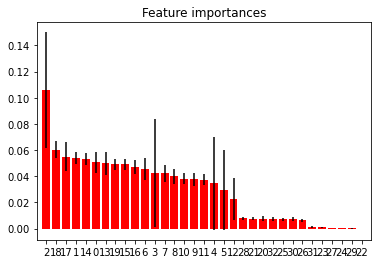

In [114]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the rfc
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [115]:
features = pd.DataFrame(zip(X_train.columns, importances), columns = ['features', 'importances'] )


In [116]:
features

,features,importances
0,limit_bal,0.050720
1,age,0.054230
2,pay_0,0.105978
3,pay_2,0.042487
4,pay_3,0.034692
5,pay_4,0.029547
6,pay_amt1,0.045454
7,pay_amt2,0.042182
8,pay_amt3,0.040092
9,pay_amt4,0.037573


In [117]:
sorted_feat = features.sort_values(by = 'importances', ascending = False)

In [118]:
sorted_feat

,features,importances
2,pay_0,0.105978
18,max_bill_to_cred_lim,0.060285
17,adjusted_bill_var,0.055085
1,age,0.054230
14,avg_bill_amt,0.053156
0,limit_bal,0.050720
13,Total_Pay_Amt,0.049887
19,paid_limit_ratio,0.049275
15,adjusted_pay_variance,0.049020
16,pay_bill_var_ratio,0.047014


/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,features,importances
2,Number_Payment_Delays,0.105978
18,max_bill_to_cred_lim,0.060285
17,adjusted_bill_var,0.055085
1,age,0.054230
14,avg_bill_amt,0.053156


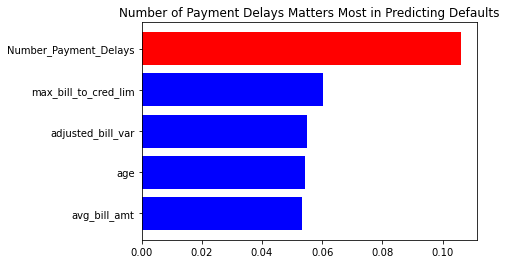

In [151]:
table = sorted_feat.head(5)
table.iloc[0,0] = 'Number_Payment_Delays'
plt.barh(table.features, table.importances, color = ['r', 'b','b','b','b'])
plt.gca().invert_yaxis()
plt.title('Number of Payment Delays Matters Most in Predicting Defaults')

table

In [120]:
#plot these features against default or not default

#app to enter in last 6 payments and predict if person will default or not

In [121]:
table = df.groupby('default_payment')[['pay_0', 'pay_2', 'max_bill_to_cred_lim',
                                      'adjusted_bill_var', 'Total_Pay_Amt',
                                      'avg_bill_amt', 'adjusted_pay_variance']].mean()

table.columns

Index(['pay_0', 'pay_2', 'max_bill_to_cred_lim', 'adjusted_bill_var',
       'Total_Pay_Amt', 'avg_bill_amt', 'adjusted_pay_variance'],
      dtype='object')

In [122]:
table.index = ['no_default', 'default']
table

,pay_0,pay_2,max_bill_to_cred_lim,adjusted_bill_var,Total_Pay_Amt,avg_bill_amt,adjusted_pay_variance
no_default,-0.198372,-0.276725,0.478710,0.727772,32286.575062,46250.893217,0.492340
default,0.688616,0.491225,0.566897,0.554871,18993.764094,44352.797173,0.357233


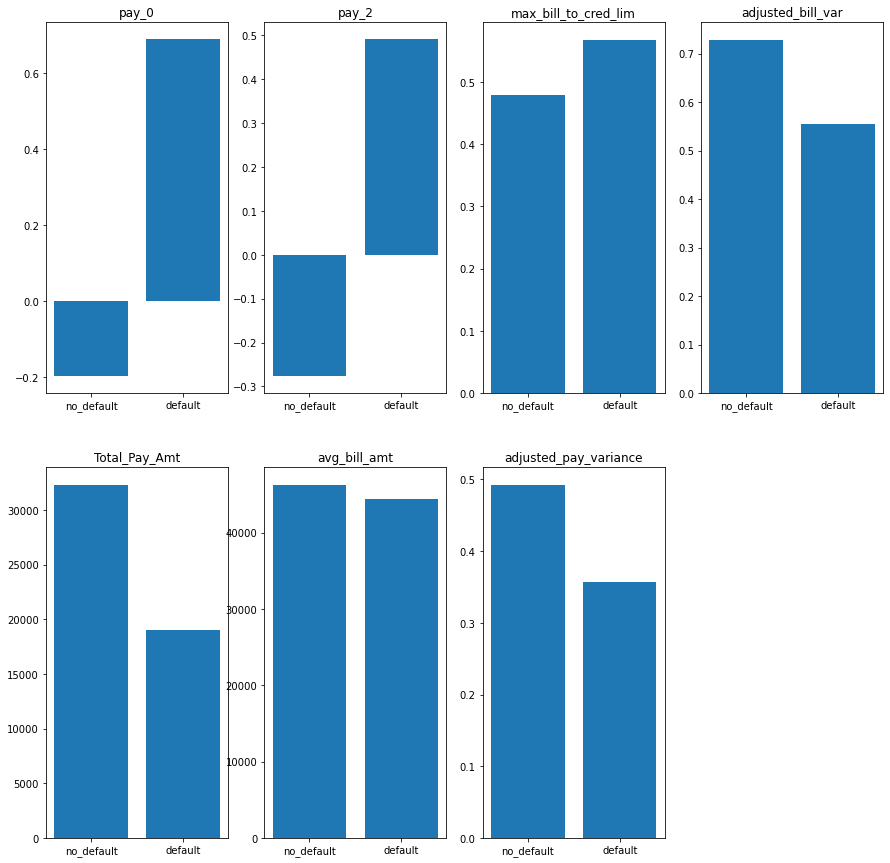

In [123]:
plt.figure(figsize = (15,15))
for i,col in enumerate(table.columns):
    plt.subplot(2,4,i+1)
    plt.bar(table.index, table[col])
    plt.title(col)


In [124]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 60,
                             max_depth = 25)
rfc.fit(X_tr, y_tr_rs)
y_pred = rfc.predict(X_te)

rfc.fit(X_tr, y_tr_rs)
y_pred = rfc.predict(X_te)


print({'Name': 'RFC', 'Recall':np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='recall')),
                           'Accuracy':np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='accuracy')), 
                            'Precision': np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='precision')),
                           'F1': np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='f1'))})


{'Name': 'RFC', 'Recall': 0.846276509146163, 'Accuracy': 0.893086513033623, 'Precision': 0.8564847063577012, 'F1': 0.849395341100917}


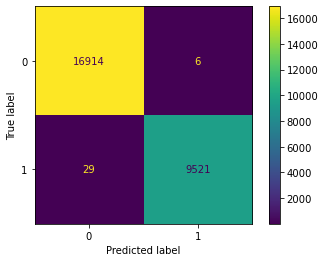

In [131]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc, X_tr, y_tr_rs)

In [129]:
confusion_matrix(y_train, y_pred)

array([[5144,  424],
       [ 980,  684]])

/Users/plam1122/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[[5144  424]
 [ 980  684]]


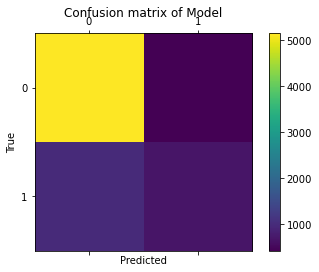

In [134]:
from sklearn.metrics import confusion_matrix

labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of Model')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()